# Importing the Required Libraries

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


# Data Loader with Data Augmentation Techniques applied

In [135]:
def load_data_cifar(batch_size):
    """Download the CIFAR-10 dataset and then load it into memory."""
    # Data Augmentation for input images
    # Transforms for training data
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # randomly flip images horizontally
        transforms.RandomRotation(10),       # randomly rotate images in the range (degrees)
        transforms.ToTensor(),  # convert the image to a tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # normalize with mean and std for CIFAR-10
    ])

# Transforms for test data (without augmentation, just normalisation)
    transform_test = transforms.Compose([
        transforms.ToTensor(), # convert the image to a tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # normalize with mean and std for CIFAR-10
    ])

    cifar_train = torchvision.datasets.CIFAR10(root="../data", train=True, transform=transform_train, download=True)
    cifar_test = torchvision.datasets.CIFAR10(root="../data", train=False, transform=transform_test, download=True)

    return (torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=2, pin_memory=True),
            torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=2, pin_memory=True))

In [116]:
batch_size = 256 # Defines the batch size
train_iter, test_iter = load_data_cifar(batch_size)

Files already downloaded and verified
Files already downloaded and verified


# The Model Architecture

### Intermediate Block

In [136]:
class IntermediateBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, num_layers, kernel_size, padding, stride):
        super(IntermediateBlock, self).__init__()
        self.num_layers = num_layers
        
        # Dynamically create convolution layers followed by batch normalisation and ReLU functions.
        self.convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size[i], padding=padding[i], stride=stride,bias=True),
                torch.nn.BatchNorm2d(output_channels),
                torch.nn.ReLU()
            ) for i in range(num_layers)
        ])

        self.fc_layer = torch.nn.Linear(in_features=input_channels, out_features=num_layers)


    def forward(self, x):
        # Calculating the mean of each channel of the input image
        m = function.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        # Passing the vector with mean values to the fully connected layer
        a = self.fc_layer(m)
        # Resizing the vector 'a' so it can be multiplied with the outputs from each convolutional layer
        a = a.view(a.size(0), a.size(1), 1, 1)

        x_prime = None

        # Processing the same image using different layers in the block (layers are not composed)
        for i, conv in enumerate(self.convs):
            Cx = conv(x)
            # Multiplication of output from convolution layer and vector 'a'
            weighted_Cx = Cx * a[:, i:i+1, :, :]
            if x_prime is None:
                x_prime = weighted_Cx
            else:
                x_prime += weighted_Cx
        
        return x_prime



In [118]:
class OutputBlock(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(OutputBlock, self).__init__()

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        # Initialising Output Block with desired hyperparameters
        self.channel_avg = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(self.num_inputs, self.num_outputs)

    def forward(self, x):
        
        out = self.channel_avg(x)
        out = self.flatten(out)
        out = self.linear(out)
        
        return out

### The Architecture Block 
#### This is where both, the intermediate and output blocks are called in the desired sequence.

In [132]:
class Architecture(torch.nn.Module):
    def __init__(self, num_outputs):
        super(Architecture, self).__init__()

        self.num_outputs = num_outputs

        # Calling the Intermediate Blocks with the desired hyperparameters
        self.imb1 = IntermediateBlock(input_channels=3, output_channels=32, num_layers=3, kernel_size=[3,5,7], padding=[0,1,2], stride=1)
        self.imb2 = IntermediateBlock(input_channels=32, output_channels=64, num_layers=5, kernel_size=[3,5,7,9,11], padding=[1,2,3,4,5], stride=1)
        self.imb3 = IntermediateBlock(input_channels=64, output_channels=128, num_layers=3, kernel_size=[3,5,7], padding=[0,1,2], stride=1)

        # Calling the Output Block with the desired hyperparameters
        self.ob = OutputBlock(128, self.num_outputs)

    def forward(self, x):

        out = self.imb1(x)
        out = self.imb2(out)
        out = self.imb3(out)
        out = self.ob(out)

        return out

# Weight Initialisation and Creation of Model

In [133]:
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

num_outputs = 10 # total number of classes

model = Architecture(num_outputs).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

Architecture(
  (imb1): IntermediateBlock(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (fc_layer): Linear(in_features=3, out_features=3, bias=True)
  )
  (imb2): IntermediateBlock(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.

# Loss Function

In [121]:
loss = torch.nn.CrossEntropyLoss()

# Optimization Algorithm

In [122]:
lr = 0.01
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

# Evaluation

In [123]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [124]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n)

In [125]:
model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.09978000074625015. Testing accuracy: 0.09779999405145645.


# Training

### First 40 epochs with learning rate 0.01

In [126]:
import time

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 40
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters
        torch.nn.utils.clip_grad_value_(model.parameters(), 1.0) # Gradient Clipper
        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.



Epoch 1/40.
Training accuracy: 0.15281999111175537. Testing accuracy: 0.15469999611377716. Duration: 30.871s.

Epoch 2/40.
Training accuracy: 0.1879199892282486. Testing accuracy: 0.19290000200271606. Duration: 31.122s.

Epoch 3/40.
Training accuracy: 0.22822000086307526. Testing accuracy: 0.23169998824596405. Duration: 31.635s.

Epoch 4/40.
Training accuracy: 0.2739799916744232. Testing accuracy: 0.2766999900341034. Duration: 29.223s.

Epoch 5/40.
Training accuracy: 0.32767999172210693. Testing accuracy: 0.3269999921321869. Duration: 31.552s.

Epoch 6/40.
Training accuracy: 0.3917199969291687. Testing accuracy: 0.3986999988555908. Duration: 31.336s.

Epoch 7/40.
Training accuracy: 0.4308599829673767. Testing accuracy: 0.4341999888420105. Duration: 31.723s.

Epoch 8/40.
Training accuracy: 0.4703199863433838. Testing accuracy: 0.47839999198913574. Duration: 31.375s.

Epoch 9/40.
Training accuracy: 0.5361599922180176. Testing accuracy: 0.5340999960899353. Duration: 31.413s.

Epoch 10/40

### Next 5 epochs with learning rate 0.001

In [127]:
lr = 0.001
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

In [128]:
num_epochs = 45
for epoch in range(40,num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters
        torch.nn.utils.clip_grad_value_(model.parameters(), 1.0) # Gradient Clipper
        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.




Epoch 41/45.
Training accuracy: 0.9180399775505066. Testing accuracy: 0.8567000031471252. Duration: 31.246s.

Epoch 42/45.
Training accuracy: 0.9277999997138977. Testing accuracy: 0.8572999835014343. Duration: 29.236s.

Epoch 43/45.
Training accuracy: 0.9293199777603149. Testing accuracy: 0.8575999736785889. Duration: 31.243s.

Epoch 44/45.
Training accuracy: 0.9304800033569336. Testing accuracy: 0.8572999835014343. Duration: 31.309s.

Epoch 45/45.
Training accuracy: 0.9325999617576599. Testing accuracy: 0.8557999730110168. Duration: 31.276s.


### Plots for losses per batch, training and testing accuracies

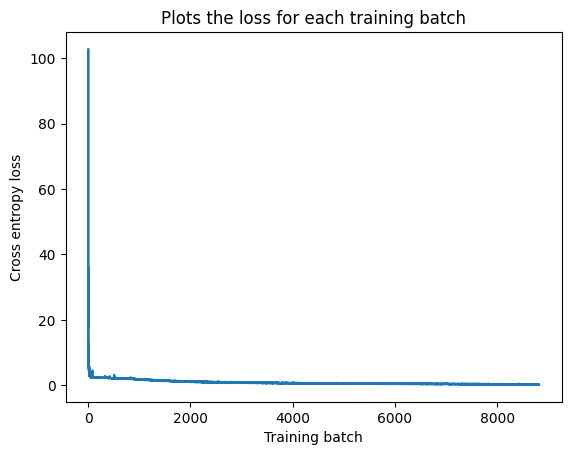

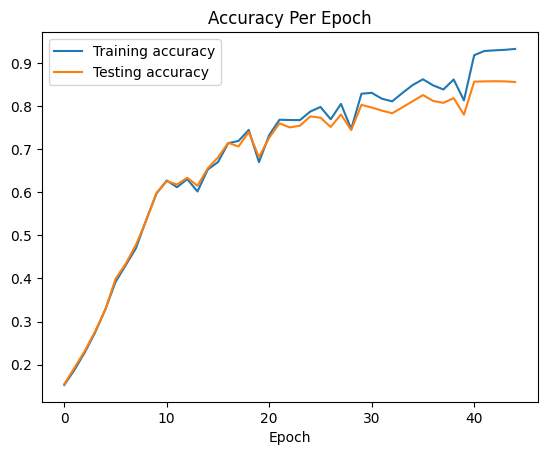

In [130]:
plt.plot(losses) # Plots the loss for each training batch
plt.title("Plots the loss for each training batch")
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.title('Accuracy Per Epoch')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()